In [6]:
import sys
import numpy as np
sys.path.append('../..')
from lib.tree_ensemble_training.german_rf import get_model
from lib.tree_extractor import path_extractor
clf, (X_train, y_train, X_test, y_test, data_table), dataset, model, parameters = get_model()
paths = path_extractor(clf, 'random forest', (X_train, y_train))

target = 'credit_risk'
X = data_table.drop(target, axis=1).values
y = data_table[target].values
from lib.tree_extractor import assign_samples, assign_value_for_random_forest
assign_samples(paths, (X, y))
# assign_value_for_random_forest(paths, (X_test, y_test))

features = data_table.columns[1:]
new_feature = {}
feature_pos = {}
for index, feature in enumerate(features):
    if ' - ' in feature:
        name, p = feature.split(' - ')
        p = int(p)
        if name not in new_feature:
            new_feature[name] = []
        while p >= len(new_feature[name]):
            new_feature[name].append(-1)
        new_feature[name][p] = index
    else:
        new_feature[feature] = [index]

feature_range = {}
for key in new_feature:
    if key in data_table.columns:
        feature_range[key] = [data_table[key].min(), data_table[key].max() + 1]
    else:
        feature_range[key] = [0, len(new_feature[key])]
    for i, j in enumerate(new_feature[key]):
        feature_pos[j] = (key, i)

for index, path in enumerate(paths):
    path['index'] = index

paths = [path for path in paths if np.sum(path['sample']) > 0]

mat = np.array([p['sample'] for p in paths]).astype('float')

for i, path in enumerate(paths):
    sum = np.sqrt(np.sum(mat[i]))
    if sum > 0:
        mat[i] /= sum

Test
Accuracy Score is 0.828
Precision Score is 0.8663101604278075
F1 Score is 0.88283378746594
Train
Accuracy Score is 0.8932692307692308


In [161]:
np.histogram([x for x in res.sorted_dist.reshape(-1) if x > 0])

(array([     180,      582,     1862,     5944,    19318,    64994,
          243102,  1035672,  4847688, 87105884]),
 array([1.11022302e-16, 1.00000000e-01, 2.00000000e-01, 3.00000000e-01,
        4.00000000e-01, 5.00000000e-01, 6.00000000e-01, 7.00000000e-01,
        8.00000000e-01, 9.00000000e-01, 1.00000000e+00]))

In [7]:
sys.path.append('../..')
from lib.data_encoding import german_credit_encoding

output_labels = ['reject', 'accept']
current_encoding = german_credit_encoding

def interpret_path(path):
    conds = {}
    for k in path['range']:
        name = feature_pos[k][0]
        val = path['range'][k]
        if name in current_encoding:
            if name not in conds:
                conds[name] = [1] * len(current_encoding[name])
            if name in data_table.columns:
                for i in range(feature_range[name][0], feature_range[name][1]):
                    if i < val[0] or i > val[1]:
                        conds[name][i - feature_range[name][0]] = 0
            else:
                if val[0] > 0:
                    conds[name] = [0] * len(current_encoding[name])
                    conds[name][feature_pos[k][1]] = 1
                else:
                    conds[name][feature_pos[k][1]] = 0
        else:
            cond = [max(feature_range[name][0], val[0]), min(feature_range[name][1], val[1])]
            conds[name] = cond

    output_conds = []
    for name in conds:
        val = conds[name]
        op = 'is'
        value = ''
        if name in current_encoding:
            is_negation = np.sum(val) * 2 >= len(val) and len(val) > 2
            if is_negation:
                op = 'is not'
                for i, d in enumerate(val):
                    if d == 0:
                        value = value + ' and ' + current_encoding[name][i]
                value = value[5:]
            else:
                for i, d in enumerate(val):
                    if d == 1:
                        value = value + ' or ' + current_encoding[name][i]
                value = value[4:]
        else:
            if val[0] == feature_range[name][0]:
                op = '<='
                value = int(val[1])
            elif val[1] == feature_range[name][1]:
                op = '>='
                value = int(val[0])
            else:
                op = 'in'
                value = '%d to %d' % (int(val[0]), int(val[1]))
        output_conds.append((name, op, value))
    output_label = output_labels[path['output']]
    # print(output_labels, path['output'])
    # print(conds)
    return output_conds, output_label

In [3]:

import matplotlib.pyplot as plt
x_tsne = np.load('path_tsne.npy')

In [46]:
from sklearn.metrics import pairwise_distances

import numpy as np
import math

from typing import Union


def run_loci(data: np.ndarray, alpha: float = 0.5, k: int = 3):
    loci_i = LOCIMatrix(data, alpha, k)
    loci_i.run()
    return loci_i



class LOCIMatrix():
    def __init__(self, data: np.ndarray, alpha: float = 0.85, k: int = 3):
        self.data = data
        self.alpha = alpha
        self.k = k

        self.max_dist = None
        self.n_points = self.data.shape[0]
        self.indice = None
        self.dist_matrix = pairwise_distances(X = self.data, metric='cosine')
        self.sorted_neighbors = np.argsort(self.dist_matrix, axis=1)
        self.sorted_dist = np.sort(self.dist_matrix, axis=1)
        self.outer_ptr = np.zeros(self.n_points).astype(int)
        self.inner_ptr = np.zeros(self.n_points).astype(int)

    def update_outer_pointer(self, r):
        ptr = self.outer_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def update_inner_pointer(self, r):
        ptr = self.inner_ptr
        for i in range(self.n_points):
            while ptr[i] < self.n_points and self.sorted_dist[i, ptr[i]] <= r:
                ptr[i] += 1

    def run(self):
        """Executes the LOCI algorithm"""
        self.result = []
        for p_ix in range(self.n_points):
            self.result.append({
                'records': [],
            })
        sqrt_n = int(math.sqrt(self.n_points))
        self.alpha = self.sorted_dist[:, 20].mean() / self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        alpha_r = 0.78
        self.rs = []
        self.alphas = []
        self.scores = [[] for _ in range(self.n_points)]

        n_steps = 20
        for i in range(n_steps, -1, -1):
            alpha = 0.8 + i * 0.01
            self.alpha = alpha
            self.alphas.append(alpha)
            r = alpha_r / alpha
            self.r = r
            self.rs.append(r)
            self.update_outer_pointer(r)
            self.update_inner_pointer(self.alpha * r)
            for p_ix in range(self.n_points):
                neighbors = self._get_sampling_N(p_ix)
                n_values = self._get_alpha_n(neighbors)
                cur_alpha_n = self._get_alpha_n(p_ix)

                n_hat = np.mean(n_values)
                mdef = 1 - (cur_alpha_n / n_hat)
                sigma_mdef = np.std(n_values) / n_hat
                self.result[p_ix]['records'].append((r, mdef, sigma_mdef))

                score = 0
                if len(neighbors) >= 20:
                    score = mdef / sigma_mdef
                self.scores[p_ix].append(score)

        r = self.sorted_dist[:, int(math.sqrt(self.n_points))].mean()
        self.scores = np.array(self.scores)
        # self.outlier_score = np.array([self.scores[i, self.indice[i]] for i in range(self.n_points)])
        return True

    def _get_sampling_N(self, p_ix: int):
        return self.sorted_neighbors[p_ix][:self.outer_ptr[p_ix]]

    def _get_alpha_n(self, indices: Union[int, np.ndarray]):
        return self.inner_ptr[indices]



In [47]:
res = run_loci(mat)

In [21]:
print(res.result[10])

{'records': [(0.78, 0.5451127819548873, 0.4701719275069163), (0.787878787878788, 0.5726618705035971, 0.5402239422394652), (0.7959183673469388, 0.578544061302682, 0.5016023256556029), (0.8041237113402061, 0.5665294924554184, 0.4972515080506277), (0.8125, 0.5629288274449564, 0.5107631776780208), (0.8210526315789474, 0.5810831902606524, 0.47390959095014057), (0.8297872340425532, 0.585435535833688, 0.475432086943197), (0.8387096774193549, 0.5809959931310819, 0.47515012600498696), (0.8478260869565217, 0.5813833890460273, 0.4703328780964511), (0.8571428571428571, 0.5839100938806276, 0.4630595684923089), (0.8666666666666667, 0.582094802567936, 0.45177156030375254), (0.8764044943820225, 0.5809027366425779, 0.46030832754339657), (0.8863636363636364, 0.5722534270788326, 0.458583030541235), (0.8965517241379309, 0.5738313016185026, 0.44669006820102725), (0.9069767441860465, 0.5748241603088042, 0.4603379819573357), (0.9176470588235294, 0.5776489239255543, 0.4474878870213503), (0.9285714285714285, 0

In [25]:
scores = []
for i, alpha in enumerate(res.alphas):
    scores.append(res.scores[:, i])
import pandas as pd
df = pd.DataFrame(res.scores)

In [40]:
(res.sorted_dist[:, 98] / res.sorted_dist[:, 200]).mean()

0.9414621506569661

In [42]:
res.alphas

[1.0,
 0.99,
 0.98,
 0.9700000000000001,
 0.9600000000000001,
 0.9500000000000001,
 0.9400000000000001,
 0.93,
 0.92,
 0.91,
 0.9,
 0.89,
 0.88,
 0.8700000000000001,
 0.8600000000000001,
 0.8500000000000001,
 0.8400000000000001,
 0.8300000000000001,
 0.8200000000000001,
 0.81,
 0.8]

In [36]:
len(set(res.scores[:, 0].argsort()[-50:][::-1].tolist() + res.scores[:, 10].argsort()[-100:][::-1].tolist()))

128

In [48]:
res.scores[:, 0].argsort()[-50:][::-1]

array([ 616,  669, 8235, 6496, 2882, 5639, 7480, 9397, 3757,   55, 2821,
       6511, 8240, 9588, 3487, 2533, 2915,  554,  687,  497, 7650, 5601,
       8961, 1234, 3226, 8020, 1713, 8019, 5980, 6057,  962, 9344,  486,
       8049, 4640, 3752, 6708, 8237, 8418, 8092, 2174, 7874, 1834, 6459,
       9598, 8260, 7805, 3762, 8340, 4555])

In [31]:
res.scores[:, 20].argsort()[-50:][::-1]

array([8415, 1072, 3486, 6455, 2009, 8018, 5639, 1888,  712, 4104, 3488,
       4117, 8092, 3878, 2817, 9501, 1939, 7361, 2915, 6491, 8389, 7367,
       7877, 8235,  543, 7878,  365, 7612, 1516, 7875,  729, 9626,  367,
         44, 6496, 2742, 5192, 5108, 3990,  703, 4125, 7475,  366, 8996,
       6494, 8702, 4007, 2181, 8645, 6801])

In [26]:
df.corr()

,0,1,2,3,4,5,6,7,8,9,...,11,12,13,14,15,16,17,18,19,20
0,1.000000,0.993229,0.986583,0.982861,0.979967,0.978090,0.975711,0.973024,0.970280,0.967103,...,0.960696,0.957439,0.954150,0.950781,0.947218,0.943029,0.938279,0.935092,0.933153,0.930465
1,0.993229,1.000000,0.993712,0.990302,0.988013,0.986297,0.984422,0.982154,0.979593,0.976843,...,0.970840,0.967804,0.964582,0.961391,0.957844,0.953740,0.949279,0.946173,0.944017,0.941197
2,0.986583,0.993712,1.000000,0.996861,0.994826,0.993239,0.991521,0.989597,0.987268,0.984744,...,0.979142,0.976170,0.973154,0.970126,0.966837,0.962819,0.958406,0.955456,0.953221,0.950336
3,0.982861,0.990302,0.996861,1.000000,0.998248,0.996893,0.995204,0.993393,0.991377,0.989033,...,0.983916,0.981018,0.978209,0.975265,0.971989,0.968133,0.963934,0.961029,0.958690,0.955836
4,0.979967,0.988013,0.994826,0.998248,1.000000,0.998751,0.997386,0.995826,0.994084,0.992026,...,0.987456,0.984806,0.982102,0.979293,0.976066,0.972427,0.968591,0.965656,0.963150,0.960406
5,0.978090,0.986297,0.993239,0.996893,0.998751,1.000000,0.998748,0.997500,0.996056,0.994217,...,0.990164,0.987693,0.985265,0.982628,0.979588,0.976110,0.972393,0.969643,0.967310,0.964642
6,0.975711,0.984422,0.991521,0.995204,0.997386,0.998748,1.000000,0.998992,0.997792,0.996281,...,0.992755,0.990653,0.988396,0.985994,0.983166,0.979893,0.976550,0.973982,0.971584,0.968959
7,0.973024,0.982154,0.989597,0.993393,0.995826,0.997500,0.998992,1.000000,0.999071,0.997832,...,0.994847,0.993012,0.991014,0.988833,0.986207,0.983086,0.979881,0.977459,0.975122,0.972643
8,0.970280,0.979593,0.987268,0.991377,0.994084,0.996056,0.997792,0.999071,1.000000,0.999073,...,0.996713,0.995109,0.993359,0.991402,0.989074,0.986246,0.983224,0.980768,0.978447,0.976087
9,0.967103,0.976843,0.984744,0.989033,0.992026,0.994217,0.996281,0.997832,0.999073,1.000000,...,0.998325,0.996991,0.995480,0.993760,0.991737,0.989278,0.986482,0.984016,0.981736,0.979534


In [22]:
for i, alpha in enumerate(res.alphas):
    print(alpha, res.scores[:, i].max(), res.scores[:, i].min(), res.scores[:, i].mean())

1.0 2.331480548818708 -5.450354220794633 0.3611352072092255
0.99 2.3629871862726834 -5.48521377565046 0.35235209095630954
0.98 2.322812334727559 -5.562841473169439 0.33968091237091175
0.9700000000000001 2.261423929036174 -5.6087980681498735 0.33041495453444536
0.9600000000000001 2.375255057131554 -5.710515701446021 0.31563425632031666
0.9500000000000001 2.4455199571188135 -5.79406682996142 0.3050592396983064
0.9400000000000001 2.23576795079712 -5.898497863130717 0.2895051272998983
0.93 2.1440827422000415 -5.993825563547828 0.2742371501516159
0.92 2.1086691015145456 -6.116068990611276 0.2575337099820885
0.91 2.2096162356370965 -6.233523865345478 0.23877969077732097
0.9 2.199671660104048 -6.324566066023281 0.21990209866981697
0.89 2.151060471960812 -6.442698099672348 0.20274141835308418
0.88 2.0036605265215965 -6.503157985087862 0.1815337314591309
0.8700000000000001 2.0100322444419936 -6.639628110271905 0.16232686744429442
0.8600000000000001 2.024073468785861 -6.727179830931627 0.1416689

In [200]:
for i, j in enumerate(res.sorted_neighbors[9501, :20]):
    print(1 - res.sorted_dist[9501, i])
    print(np.sum(mat[9501] * mat[j] > 0) / len(np.flatnonzero(np.array(paths[9501]['sample']) + np.array(paths[j]['sample']))))

1.0
1.0
0.6063390625908325
0.43478260869565216
0.40824829046386313
0.2222222222222222
0.3872983346207417
0.24
0.33407655239053047
0.2
0.33333333333333326
0.19047619047619047
0.30618621784789735
0.17647058823529413
0.30151134457776363
0.17391304347826086
0.2946278254943948
0.1724137931034483
0.2773500981126146
0.16
0.2581988897471612
0.14814814814814814
0.25
0.1111111111111111
0.25
0.0625
0.2461829819586655
0.10810810810810811
0.24253562503633297
0.13793103448275862
0.2405626121623441
0.13157894736842105
0.2357022603955159
0.13333333333333333
0.2294157338705618
0.12903225806451613
0.2261335084333227
0.125
0.22360679774997905
0.10909090909090909


In [84]:
np.quantile(res.sorted_dist[:, :98], 0.2)

0.6533123773592318

In [145]:
anomaly = res.sorted_dist[:, 20].argsort()
print(len(anomaly))

9661


array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.  

In [65]:
int(math.sqrt(res.n_points))

98

In [58]:
for i in [4657, 7567, 7845, 3400, 6290]:
    print(interpret_path(paths[i]))

([('employment_duration', 'is not', 'unemployed and < 1 yr'), ('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('housing', 'is', 'own'), ('duration', '>=', 11), ('status', 'is not', '... >= 200 DM (salary)'), ('other_installment_plans', 'is', 'none'), ('job', 'is', 'skilled employee / official'), ('other_debtors', 'is not', 'none')], 'accept')
([('employment_duration', 'is not', 'unemployed and < 1 yr'), ('purpose', 'is', 'furniture/equipment'), ('housing', 'is not', 'rent'), ('installment_rate', 'is not', '< 20 and 20 to 25'), ('property', 'is', 'real estate'), ('present_residence', 'is not', '>= 7 yrs')], 'accept')
([('housing', 'is', 'own'), ('employment_duration', 'is not', 'unemployed and < 1 yr'), ('telephone', 'is', 'No'), ('purpose', 'is not', 'others and car (used)'), ('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('amount', '<=', 3565), ('duration', '<=', 8)], 'accept')
([('credit_history', 'is', 'existing credits paid back du

In [29]:
order = res.outlier_score.argsort()
order_score = res.outlier_score[order]
rank = [0 for i in range(res.n_points)]
for i, j in enumerate(order):
    rank[j] = i
xs = [i for i in range(res.n_points)]
xs = np.array(xs)
deeprules = [i for i in range(res.n_points) if len(interpret_path(paths[i])[0]) > 9]

In [100]:
res.sorted_dist[:, 98].mean()

0.7764802800670986

In [32]:

mat = np.array([p['sample'] for p in paths]).astype('float')
samples = mat.sum(axis = 1)


In [154]:
for i in res.sorted_neighbors[9626][1:5]:
    print(i, interpret_path(paths[i]))

8189 ([('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('installment_rate', 'is not', '< 20 and 20 to 25'), ('age', '<=', 46), ('telephone', 'is', 'No'), ('housing', 'is not', 'own'), ('duration', '>=', 15), ('employment_duration', 'is', '4 to 7 yrs or >= 7 yrs')], 'reject')
5829 ([('credit_history', 'is', 'no credits taken/all credits paid back duly'), ('other_debtors', 'is not', 'guarantor'), ('telephone', 'is', 'No'), ('duration', '>=', 21), ('savings', 'is not', '>= 1000 DM'), ('employment_duration', 'is', '4 to 7 yrs or >= 7 yrs'), ('present_residence', 'is', '>= 7 yrs')], 'accept')
612 ([('savings', 'is not', '500 to 1000 DM and >= 1000 DM'), ('duration', '>=', 12), ('status', 'is not', '0 to 200 DM and ... >= 200 DM (salary)'), ('job', 'is', 'skilled employee / official'), ('personal_status_sex', 'is', 'married male'), ('employment_duration', 'is', '4 to 7 yrs or >= 7 yrs'), ('number_credits', 'is', '1')], 'reject')
543 ([('purpose', 'is not', 'furniture

In [94]:
outliers = res.scores[:, 210].argsort()[-50:]

In [185]:
for i in res.sorted_neighbors[9501][:2]:
    print(interpret_path(paths[i]), paths[i]['confidence'])

([('credit_history', 'is not', 'all credits at this bank paid back duly'), ('duration', '>=', 12), ('housing', 'is', 'own'), ('amount', '<=', 1047)], 'accept') 0.6666666666666666
([('duration', '>=', 15), ('purpose', 'is not', 'car (used)'), ('property', 'is not', 'unknown / no property'), ('amount', '<=', 1077)], 'accept') 0.7368421052631579


In [187]:
for i in res.sorted_neighbors[5258][:1]:
    print(interpret_path(paths[i]), paths[i]['confidence'])

([('other_installment_plans', 'is not', 'bank'), ('housing', 'is not', 'rent'), ('property', 'is not', 'unknown / no property'), ('present_residence', 'is', '>= 7 yrs'), ('number_credits', 'is', '1'), ('personal_status_sex', 'is', 'not married male'), ('duration', '<=', 19), ('age', '<=', 51)], 'accept') 0.7142857142857143


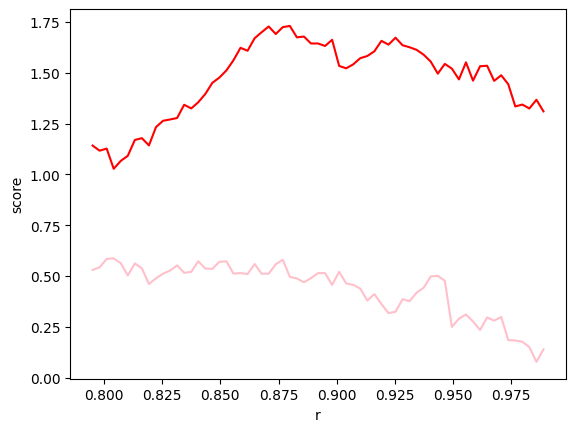

In [181]:
fig, ax = plt.subplots()
fp = [5258]#[9501, 6801, 5258, 9626]
fp_neighbors = []
for i in fp:
    for j in range(1, 10):
        if res.sorted_dist[i, j] < 0.7:
            fp_neighbors.append(res.sorted_neighbors[i, j])

for x in fp_neighbors[1:2]:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][180:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][180:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][180:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='pink')

for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][180:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][180:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][180:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='red')
ax.set_xlabel('r')
ax.set_ylabel('score')
#  ax.legend()
plt.show()

<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-137-2755866fbd30>:8: Runt

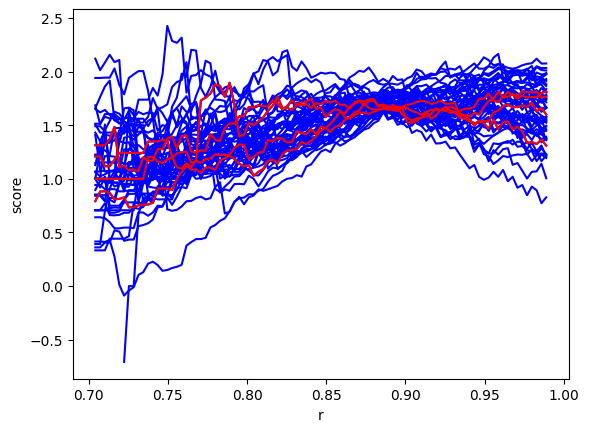

In [137]:
fig, ax = plt.subplots()
tp = outliers
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [9501, 6801, 5258, 9626]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:-5]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:-5]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:-5]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
ax.set_xlabel('r')
ax.set_ylabel('score')
#  ax.legend()
plt.show()

<ipython-input-188-4df430bf518b>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-188-4df430bf518b>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-188-4df430bf518b>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-188-4df430bf518b>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
<ipython-input-188-4df430bf518b>:8: RuntimeWarning: invalid value encountered in true_divide
  ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')


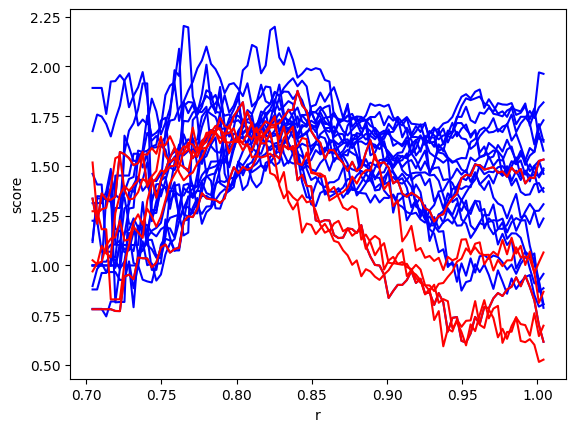

In [188]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='r')
normal = []#[1,2,3,4,5,6,7,8,9,10]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score', color='g')
ax.set_xlabel('r')
ax.set_ylabel('score')
# ax.set_yscale('log')
#  ax.legend()
plt.show()

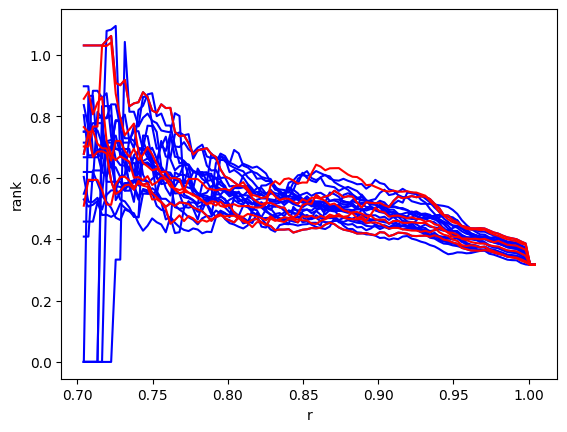

In [164]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, s_mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, s_mdefs, label=str(x) + ' score', color='r')
ax.set_xlabel('r')
ax.set_ylabel('rank')
#  ax.legend()
plt.show()

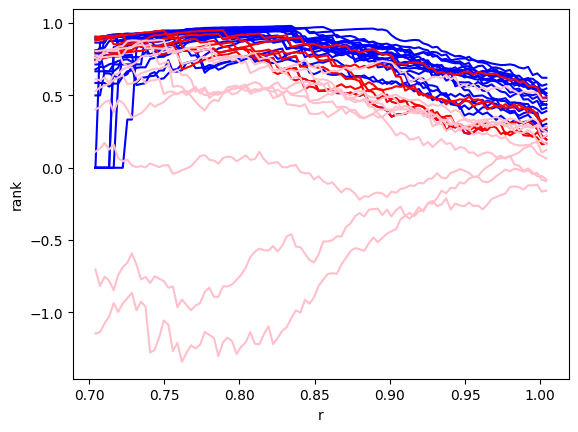

In [168]:
fig, ax = plt.subplots()
tp = res.outlier_score.argsort()[-20:]
for x in tp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='b')
fp = [8629, 1193, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='r')
normal = [i for i in range(100, 200, 10)]
for x in normal:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][150:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][150:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][150:]])
    ax.plot(xs, mdefs, label=str(x) + ' score', color='pink')
ax.set_xlabel('r')
ax.set_ylabel('rank')
#  ax.legend()
plt.show()

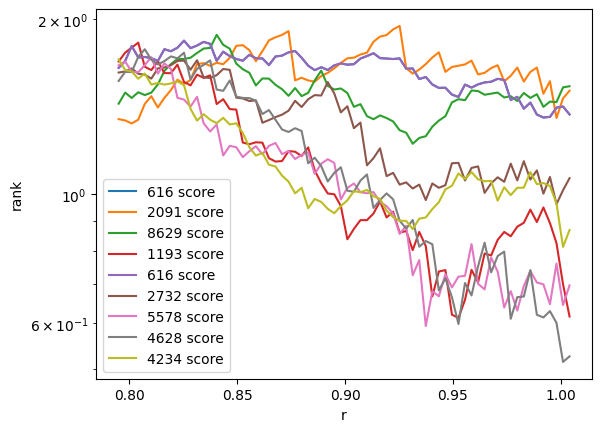

In [66]:
fig, ax = plt.subplots()
fp = [616, 2091, 8629, 1193, 616, 2732, 5578, 4628, 4234]
for x in fp:
    ranks = []
    xs = [y[0] for y in res.result[x]['records'][180:]]
    mdefs = np.array([y[1] for y in res.result[x]['records'][180:]])
    s_mdefs = np.array([y[2] for y in res.result[x]['records'][180:]])
    # for i in range(180, res.scores.shape[1]):
    #     rank = np.sum(res.scores[:, i] > res.scores[x, i])
    #     ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, mdefs / s_mdefs, label=str(x) + ' score')
    # ax.plot(xs, mdefs, label=str(x) + ' MDEF')
    # ax.plot(xs, s_mdefs, label=str(x) + ' S_MDEF')
ax.set_xlabel('r')
ax.set_ylabel('rank')
ax.set_yscale('log')
ax.legend()
plt.show()

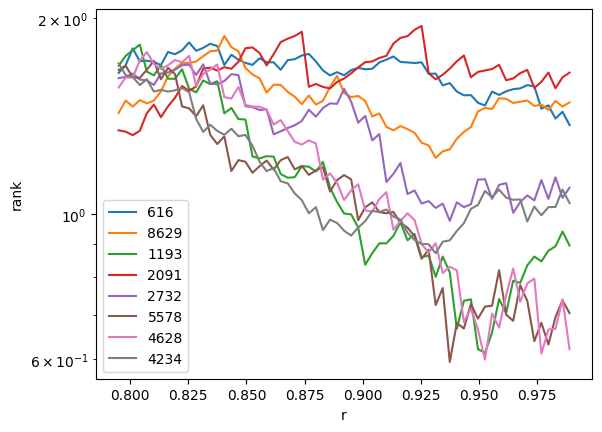

In [78]:
fig, ax = plt.subplots()
fp = [616, 8629, 1193, 2091, 2732, 5578, 4628, 4234]
#fp = [1,2,4,5,6]
for x in fp:
    ranks = []
    xs = res.rs[180:-5]
    for i in range(180, res.scores.shape[1] - 5):
        rank = res.scores[x, i]
        ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, ranks, label=str(x))
ax.set_xlabel('r')
ax.set_ylabel('rank')
ax.set_yscale('log')
ax.legend()
plt.show()

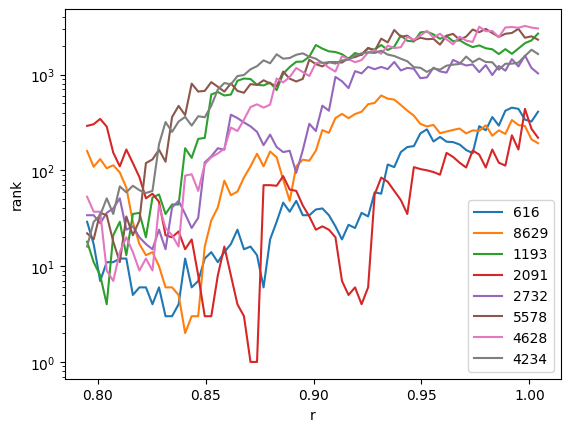

In [70]:
fig, ax = plt.subplots()
fp = [616, 8629, 1193, 2091, 2732, 5578, 4628, 4234]
# fp = [1,2,4,5,6,7]
for x in fp:
    ranks = []
    xs = res.rs[180:]
    for i in range(180, res.scores.shape[1]):
        rank = np.sum(res.scores[:, i] > res.scores[x, i])
        ranks.append(rank)
    # print(xs, ranks)
    ax.plot(xs, ranks, label=str(x))
ax.set_xlabel('r')
ax.set_ylabel('rank')
ax.set_yscale('log')
ax.legend()
plt.show()

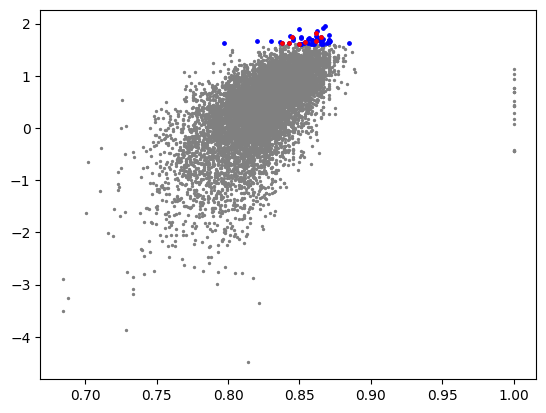

In [53]:
#deeprules = res.outlier_score.argsort()[-50:][::-1]
knn = res.sorted_dist[:, 200]
other = res.outlier_score.argsort()[-50:]
fp = [616, 8629, 1193, 2091, 2732, 5578, 4628, 4234]
plt.scatter(knn, res.outlier_score, s = 2, color='gray')
plt.scatter(knn[other], res.outlier_score[other], s = 6, color='blue')
plt.scatter(knn[fp], res.outlier_score[fp], s = 6, color='red')
plt.show()

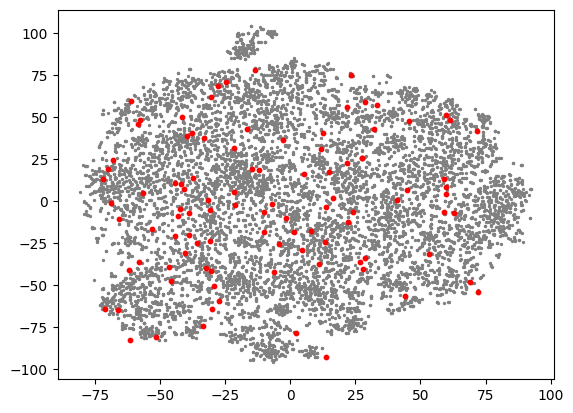

In [45]:
step = (res.rs[1] - res.rs[0])
r_min = res.rs[0]
sqrt_n = int(math.sqrt(res.n_points))
res.outlier_indices = [int((res.sorted_dist[i, sqrt_n] - r_min) / step) for i in range(res.n_points)]
res.scores = np.array(res.scores)
#res.outlier_score = np.array([res.scores[i, res.outlier_indices[i]] for i in range(res.n_points)])
res.outlier_score = np.array([res.scores[i, int((res.sorted_dist[i, sqrt_n] - r_min) / step)] for i in range(res.n_points)])

anomaly = res.outlier_score.argsort()[-100:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

In [127]:

anomaly = 
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[anomaly, 0], x_tsne[anomaly, 1], s = 10, color='red')
plt.show()

1.1354041026140427

In [29]:
x_sample_tsne = x_tsne[:500]

In [42]:
print(res.sorted_dist[anomaly2, 20].mean())
print(res.sorted_dist[:500, 20].mean())
print(res.sorted_dist[res.sorted_dist[:500, 20].argsort()[-5:], 20])

0.6871191895786511
0.6664664251176068
[0.77207885 0.77354459 0.7807355  0.78995799 0.80635083]


In [143]:
res.outlier_score[res.outlier_score.argsort()[::-1][300]]

1.3645458988908608

In [61]:
non_anomaly = np.flatnonzero(res.outlier_score < 1)

In [20]:
np.argmin(res.scores[1647][180:])

47

In [66]:
for it, i in enumerate(res.sorted_neighbors[9185][:20]):
    print(i, res.outlier_score[i], 1 - res.sorted_dist[9185, it])

9185 0.3757191739064244 1.0
4134 -0.05918258675369054 0.5577733510227172
3773 0.598619501510504 0.5179323973782373
8462 -0.29178030029391455 0.5041183773141629
4249 -0.7843166184503516 0.46947647786157076
678 0.06289839382456602 0.46409548089225705
532 -0.7512068250736634 0.42761798705987897
2071 0.505833578347433 0.41576092031015
6108 0.4397910242557188 0.4057411124598246
827 0.75821759683563 0.40118870990143896
5228 0.32654607151571646 0.39440531887330765
1454 0.2597734977241268 0.3795360576382949
2118 0.5963679247390012 0.3766588923446066
7971 0.31615101624178793 0.3733393086486333
1919 0.6474377020916215 0.3688555567816587
2668 0.45879286514007867 0.3646464492724877
4049 1.015637482434589 0.3603749850782235
1555 -0.4542745733053593 0.358568582800318
3573 0.485900047401699 0.34914862437758787
9240 0.15899858743818493 0.3490050304482666


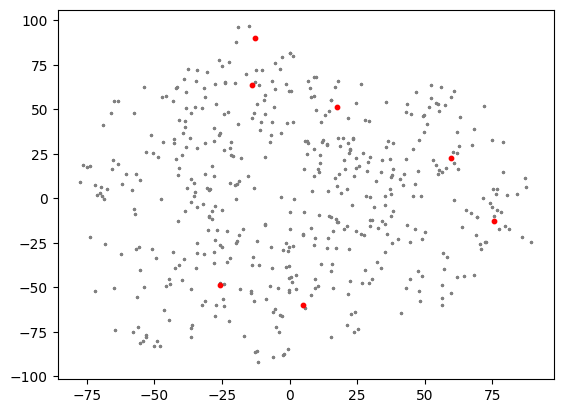

In [103]:

anomaly = res.outlier_score.argsort()[-100:][::-1]
anomaly2 = [i for i in anomaly if i < 500]
anomaly3 = res.sorted_dist[:500, 20].argsort()[-5:]
plt.scatter(x_sample_tsne[:, 0], x_sample_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_sample_tsne[anomaly2, 0], x_sample_tsne[anomaly2, 1], s = 10, color='red')
plt.show()

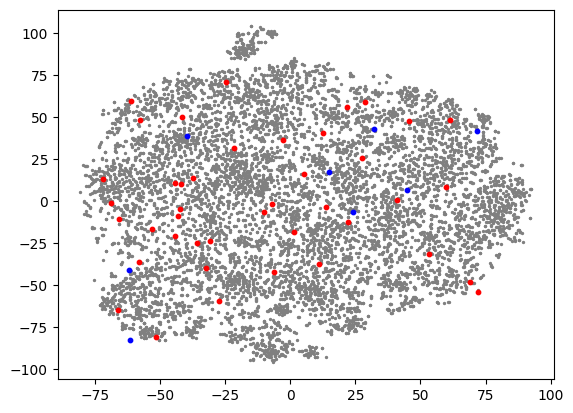

In [133]:
label = '11110110111110111111111101111111110101110111011111'
anomaly = anomaly[:50]
tp = [j for i, j in enumerate(anomaly) if label[i] == '1']
fp = [j for i, j in enumerate(anomaly) if label[i] == '0']
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[tp, 0], x_tsne[tp, 1], s = 10, color='red')
plt.scatter(x_tsne[fp, 0], x_tsne[fp, 1], s = 10, color='blue')
plt.show()

In [55]:
(res.scores[:, 240] > res.scores[3485, 240]).sum()

49

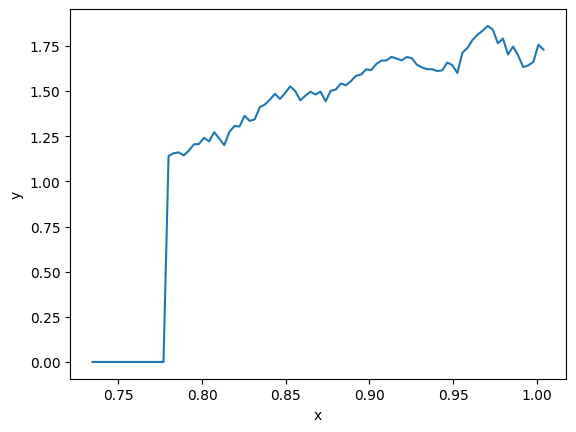

In [52]:

import pandas as pd
import seaborn as sns

linedata = pd.DataFrame({
    'y': [res.scores[3485, k] for k in range(160, len(res.rs), 1)],
    'x': [res.rs[k] for k in range(160, len(res.rs), 1)],
}, columns=['x', 'y'])
sns.lineplot(x="x",
             y="y",
             data=linedata)

plt.show()


In [57]:
res.rs[res.outlier_indices[616]]

0.834443079104808

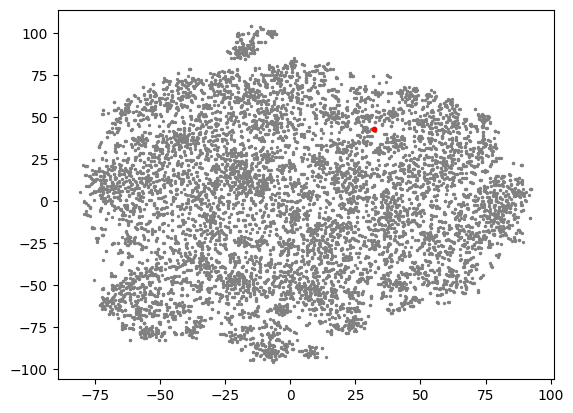

In [113]:
anomaly = res.outlier_score.argsort()[-50:][::-1]
#print(anomaly)
plt.scatter(x_tsne[:, 0], x_tsne[:, 1], s = 2, color='gray')
plt.scatter(x_tsne[[4234], 0], x_tsne[[4234], 1], s = 10, color='red')
plt.show()

In [7]:
for i in [2]:
    print(interpret_path(paths[i]))

([('savings', 'is', 'unknown/no savings account'), ('property', 'is not', 'unknown / no property'), ('purpose', 'is not', 'furniture/equipment'), ('duration', '<=', 12), ('amount', '>=', 922), ('number_credits', 'is not', '2 to 3'), ('telephone', 'is', 'Yes')], 'accept')


In [93]:
res.outlier_score[res.outlier_score.argsort()[-50:][::-1]]

array([1.81242375, 1.80767886, 1.78966401, 1.78953929, 1.75713243,
       1.75381015, 1.74771078, 1.74419956, 1.73731884, 1.72148037,
       1.71714098, 1.71123606, 1.70971684, 1.70914067, 1.70600345,
       1.70223887, 1.70124351, 1.68483128, 1.67844404, 1.67501449,
       1.66953475, 1.66201002, 1.66092075, 1.65959516, 1.65830554,
       1.65525755, 1.65409493, 1.65127661, 1.64876369, 1.63927103,
       1.63272569, 1.62806504, 1.62184761, 1.62162829, 1.62085559,
       1.62084007, 1.61991311, 1.61649677, 1.61141477, 1.61048634,
       1.60719362, 1.60626457, 1.60532553, 1.60356745, 1.59290624,
       1.58735158, 1.58558786, 1.58345326, 1.58029894, 1.57993553])

In [4]:
import math

In [49]:
rules = []
class_count = {}
all_labels = {}
max_n_conds = 0
top_n = 200
filtered_id = {}
count = 0
idxes = res.scores[:, 0].argsort()[-50:][::-1].tolist()
anomalies = 0
for it, i in enumerate(idxes):
    conds, output = interpret_path(paths[i])
    class_count[output] = class_count.get(output, 0) + 1
    if i in all_labels:
        if all_labels[i] == '1':
            anomalies += 1
        j = it + 1
        if j == 10 or j == 20 or j == 50:
            print('precision@%d: %.2f' % (j, anomalies / j))
    label = all_labels.get(i, -1)
    count += 1
    rules.append({'cond': conds, 'predict': output, 'index': i, 'order': it, 'attr': 0, 'labels': int(label) })
    max_n_conds = max(len(conds), max_n_conds)
conds_per_line = 4
max_n_conds = math.ceil(max_n_conds / conds_per_line) * conds_per_line

f = open('loci_070304.csv', 'w')

for it, rule in enumerate(rules):
    s = '' + str(rule['order'])
    line = 0
    n_conds = len(rule['cond'])
    n_lines = math.ceil(n_conds / conds_per_line)
    index = rule['index']

    for line in range(n_lines):
        if line == 0:
            s += ',#%d,IF,' % (index)
        else:
            s += ',,,'
        for pos in range(conds_per_line):
            i = pos + line * conds_per_line
            if i < n_conds:
                item = rule['cond'][i]
                s += item[0] + ',' + item[1] + ',' + str(item[2]) + ','
                s += 'AND,' if i < n_conds - 1 else '...,'
            else:
                s += '...,...,...,...,'
        if line == n_lines - 1:
            s = s[:-4]
            s += 'THEN,%s,%d,%3f' % (rule['predict'], np.sum(paths[index]['distribution']), paths[index]['confidence'])
        s += '\n'
    f.write(s + '\n')
f.close()

In [26]:
all_labels = {7305: '1', 8624: '0', 1884: '1', 468: '1', 6290: '0', 8055: '0', 2280: '1', 3400: '1', 4466: '0', 4650: '0', 6028: '1', 4459: '1', 1411: '1', 665: '0', 868: '1', 8911: '1', 3848: '0', 9283: '0', 5218: '0', 3035: '0', 1010: '1', 8934: '1', 6483: '1', 2807: '1', 5767: '1', 1763: '1', 4479: '1', 679: '1', 873: '1', 6641: '1', 178: '0', 2278: '1', 7567: '0', 287: '1', 7527: '1', 6569: '1', 3487: '1', 2363: '1', 1750: '0', 2300: '1', 6277: '0', 8240: '1', 7499: '1', 525: '0', 4785: '0', 9324: '0', 3337: '1', 3617: '1', 5003: '1', 2089: '1', 3204: '1', 991: '1', 2167: '1', 3488: '1', 1507: '1', 1840: '1', 4932: '1', 254: '1', 9096: '1', 5974: '0', 7529: '1', 2764: '1', 9134: '1', 2112: '0', 7845: '0', 8073: '1', 4657: '0', 3270: '1', 5502: '1', 616: '1', 6787: '0', 6801: '1', 3486: '1', 405: '1', 3485: '1', 8092: '1', 1393: '0', 668: '1', 8389: '0', 2277: '1', 8629: '0', 1520: '1', 4104: '1', 712: '0', 6952: '1', 1330: '1', 8415: '1', 6471: '1', 690: '1', 5575: '1', 5590: '0', 5252: '0', 2079: '1', 1940: '0', 3891: '1', 2916: '0', 1939: '1', 6839: '0', 4384: '1', 3628: '1', 2664: '1', 8645: '1', 7572: '1', 736: '0', 2228: '1', 4759: '1', 729: '0', 4980: '1', 2009: '1', 2099: '0', 4995: '0', 7810: '1', 7571: '1', 5459: '0', 2817: '0', 4812: '1', 4983: '0', 6289: '0', 8022: '0', 4647: '1', 3618: '1', 9452: '1', 4978: '1', 4350: '1', 2706: '1', 758: '1', 2500: '0', 1017: '0', 7915: '0', 5237: '1', 1963: '1', 7556: '0', 3451: '1', 4977: '1', 7456: '1', 424: '1', 4867: '1', 2279: '1', 4234: '0', 3313: '1', 1703: '1', 9289: '0', 827: '0', 8258: '1'}

In [23]:
for i, label in enumerate('11101000111111101011011110000110101110111101111001'):
    all_labels[anomaly[i]] = label

In [25]:
print(all_labels)

{7305: '1', 8624: '0', 1884: '1', 468: '1', 6290: '0', 8055: '0', 2280: '1', 3400: '1', 4466: '0', 4650: '0', 6028: '1', 4459: '1', 1411: '1', 665: '0', 868: '1', 8911: '1', 3848: '0', 9283: '0', 5218: '0', 3035: '0', 1010: '1', 8934: '1', 6483: '1', 2807: '1', 5767: '1', 1763: '1', 4479: '1', 679: '1', 873: '1', 6641: '1', 178: '0', 2278: '1', 7567: '0', 287: '1', 7527: '1', 6569: '1', 3487: '1', 2363: '1', 1750: '0', 2300: '1', 6277: '0', 8240: '1', 7499: '1', 525: '0', 4785: '0', 9324: '0', 3337: '1', 3617: '1', 5003: '1', 2089: '1', 3204: '1', 991: '1', 2167: '1', 3488: '1', 1507: '1', 1840: '1', 4932: '1', 254: '1', 9096: '1', 5974: '0', 7529: '1', 2764: '1', 9134: '1', 2112: '0', 7845: '0', 8073: '1', 4657: '0', 3270: '1', 5502: '1', 616: '1', 6787: '0', 6801: '1', 3486: '1', 405: '1', 3485: '1', 8092: '1', 1393: '0', 668: '1', 8389: '0', 2277: '1', 8629: '0', 1520: '1', 4104: '1', 712: '0', 6952: '1', 1330: '1', 8415: '1', 6471: '1', 690: '1', 5575: '1', 5590: '0', 5252: '0', 20